<a href="https://colab.research.google.com/github/niveousdragon/network_analysis/blob/main/Network_analysis_2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Analytic distributions { form-width: "300px" }
def chaotic_angle_distr(x):
    #return 1./2/np.pi - 9./64*np.cos(x)
    return (44 + 15*np.pi - 45*np.cos(x))/16/np.pi
 
def chaotic_radial_distr(x):
    #return 1./2/np.pi - 9./64*np.cos(x)
    return 24*x**3/(1+x**2)**4

In [ ]:
#@title Plot { form-width: "300px" }
import networkx as nx
from scipy import isinf, sqrt, errstate
import scipy.sparse as sp
import scipy.stats as st
import numpy as np
import random
import matplotlib.pyplot as plt
#from numpy import linalg as la
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def change_labels_color(ax):
    pass
    '''
    [t.set_color('white') for t in ax.xaxis.get_ticklines()]
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklines()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]
    '''
    #ax.xaxis.get_l.set_color('white')
    #ax.ylabel.set_color('white')

def prepare_grid(x,y):
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return (xmin, xmax, ymin, ymax, xx, yy, f)

def prepare_figure(dim = 2):
    fig = plt.figure(figsize=(15, 10))
    proj = '3d' if dim == 3 else None
    ax = plt.axes(projection=proj)
    change_labels_color(ax)
    ax.set_xlabel('real')
    ax.set_ylabel('imag')
    if dim == 3:
        ax.set_zlabel('PDF')
        ax.set_title('Surface plot of Gaussian 2D KDE', c = 'w')
    else:
        ax.set_title('2D Gaussian Kernel density estimation')

    return fig, ax

def plot_3d_z_distr(ensemble):
    zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
    x, y = np.real(zvals), np.imag(zvals)
    (xmin, xmax, ymin, ymax, xx, yy, f) = prepare_grid(x,y)
    fig, ax = prepare_figure(dim = 3)

    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    color_bar = fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
    cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                
    plt.setp(cbytick_obj, color='w')
    ax.view_init(60, 60)

def plot_2d_z_distr(ensemble, ax = None, return_figure=0, arraylist = None):
    if arraylist is None:
        zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
    else:
        zvals = np.concatenate(arraylist)

    x, y = np.real(zvals), np.imag(zvals)
    if np.allclose(y, 0):
        raise Exception('2D z-distribution is not available in case of real spectrum')
    (xmin, xmax, ymin, ymax, xx, yy, f) = prepare_grid(x,y)
    #ax.set_xlim(xmin, xmax)
    #ax.set_ylim(ymin, ymax)
    if ax is None:
        fig, ax = prepare_figure(dim = 2)
        
    ax.title.set_color('white')

    cfset = ax.contourf(xx, yy, f, levels = 10, cmap='coolwarm')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)
    if return_figure:
        return ax

def plot_1d_distr(x, ax = None):
    import seaborn as sns

    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 12))
        
    sns.set_style('whitegrid')
    sns.distplot(np.array(x), bins = 100, ax = ax)
    #sns.kdeplot(np.array(x), bw=0.02)

def get_localization_stats(ensemble, arraylist = None):
    if arraylist is None:
        zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
    else:
        zvals = np.concatenate(arraylist)

    mean_cos_phi = np.mean(np.array([np.cos(np.angle(x)) for x in zvals]))
    print('mean cos phi complex:', mean_cos_phi)

    if np.allclose(np.abs(zvals.imag), np.zeros(len(zvals))):
        rvals = zvals
    else:
        rvals = [np.abs(x) for x in zvals]

    rvals = [1./r**2 for r in rvals]

    mean_inv_r_sq = np.mean(np.array(rvals))
    print('mean 1/r^2 real:', mean_inv_r_sq)

    return mean_inv_r_sq, mean_cos_phi

def plot_angle_z_distr(zvals, ax = None, nbins = 100, inverse = 0):
    if inverse:
        angles = [1/np.angle(x) for x in zvals]
        bins = np.linspace(min(angles), max(angles), nbins)
        
    else:
        angles = [np.angle(x) for x in zvals]
        bins = np.linspace(-np.pi, np.pi, nbins)

    if ax is None:
        fig, ax = plt.subplots(figsize = (16,12))

    #change_labels_color(ax)
    ax.hist(angles, bins, alpha=0.5, density = True)
    '''
    x = np.linspace(-np.pi, np.pi, 1000)
    theory = [chaotic_angle_distr(a) for a in x]
    ax.plot(x, theory)
    '''
def plot_radial_z_distr(zvals, ax = None, nbins = 100, inverse = 0):
    if np.allclose(np.abs(zvals.imag), np.zeros(len(zvals))):
        rvals = zvals
        nbins = 2*nbins
        bins = np.linspace(-1.05, 1.05, nbins)
    else:
        rvals = [np.abs(x) for x in zvals]
        bins = np.linspace(0, 1.05, nbins)
    
    logview = False
    if inverse:
        rvals = [1./r**2 for r in rvals]
        #print(rvals)
        logview = True
        bins = np.linspace(min(rvals), max(rvals), nbins)

    if ax is None:
        fig, ax = plt.subplots(figsize = (16,12))
    #change_labels_color(ax)
    ax.hist(rvals, bins, alpha=0.5, density = True, log = logview)
    '''
    x = np.linspace(0, 1, 1000)
    theory = [chaotic_radial_distr(m) for m in x]
    ax.plot(x, theory)
    '''

    
def plot_eigs(eigs):
    fig,ax = plt.subplots(figsize = (12,12))
    ax.set(xlim=(1-max(eigs.real), 1+max(eigs.real)), ylim = (-max(eigs.imag), max(eigs.imag)))
    ax.scatter(eigs.real,eigs.imag)

def plot_separate(arr):
    if np.allclose(np.abs(arr.imag), np.zeros(len(arr))):
        #print('******** REAL SPECTRUM: **********')
        plot_1d_distr(arr.real)
    else:
        z_complex, z_real = separate(arr)
        #print(z_real.real)
        #print('******** COMPLEX SPECTRUM: **********')
        plot_2d_distr(z_complex.real,z_complex.imag)
        #print('******** REAL SPECTRUM: **********')
        plot_1d_distr(z_real.real)

def plot_separate_marginal_distr(ensemble, nbins = 100, arraylist = None):
    # Create 2x2 sub plots
    fig = plt.figure(figsize = (15,10))
    fig.suptitle('Marginal distributions')
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    if arraylist is None:
        zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
    else:
        zvals = np.concatenate(arraylist)
        
    z_complex, z_real = separate(zvals)
    print(len(z_complex), 'complex zvals', len(z_real), 'real zvals')
    plot_radial_z_distr(z_complex, ax = ax1, nbins = nbins)
    plot_angle_z_distr(z_complex, ax = ax2, nbins = nbins)
    plot_radial_z_distr(z_real, ax = ax3, nbins = nbins)
    plot_angle_z_distr(z_real, ax = ax4, nbins = nbins)

def plot_modified_separate_marginal_distr(ensemble, nbins = 100, arraylist = None):
    # Create 2x2 sub plots
    fig = plt.figure(figsize = (15,10))
    fig.suptitle('Marginal distributions')
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title('Z complex r distribution', c = 'k')
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title('Z complex 1/phi distribution', c = 'k')
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title('Z real 1/r distribution', c = 'k')
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title('Z real phi distribution', c = 'k')

    if arraylist is None:
        zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
    else:
        zvals = np.concatenate(arraylist)
        
    z_complex, z_real = separate(zvals)
    print(len(z_complex), 'complex zvals', len(z_real), 'real zvals')
    plot_radial_z_distr(z_complex, ax = ax1, nbins = nbins, inverse = 0)
    plot_angle_z_distr(z_complex, ax = ax2, nbins = nbins, inverse = 1)
    plot_radial_z_distr(z_real, ax = ax3, nbins = nbins, inverse = 1)
    plot_angle_z_distr(z_real, ax = ax4, nbins = nbins, inverse = 0)

def plot_marginal_z_distr(ensemble):
    # Create 2 sub plots
    fig = plt.figure(figsize = (15,10))
    fig.suptitle('Marginal distributions')
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    fig.tight_layout(pad=3.0)

    zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]

    plot_radial_z_distr(zvals, ax = ax1)
    #plot_1d_distr(zvals.real, ax = ax1)
    #plot_1d_distr(zvals.imag, ax = ax2)
    plot_angle_z_distr(zvals, ax = ax2)

def plot_ipr_entropy(ensemble, separate = 0, first_eigs = 1, ax = None):

    if ax is None:
        fig, ax = plt.subplots(figsize = (15,10))
        
    change_labels_color(ax)
    clist = ['k', 'y', 'b']
    
    if separate:
        entropy_list = []
        eigvals_list = []
        for net in ensemble:
            entropy_list.append(ravel_ensemble_data([net], ['erdos_entropy'])[0])
            eigvals_list.append(ravel_ensemble_data([net], ['spectrum'])[0])
        
        ax.set(ylim = (0, max(max(entropy_list[0]), max(entropy_list[1])) + 0.5))
        for i in range(len(ensemble)):
            entropy = entropy_list[i]
            eigvals = eigvals_list[i]
            if first_eigs:
                ax.scatter(eigvals[:20], entropy[:20], c = clist[i])
            else:
                ax.scatter(eigvals, entropy, c = clist[i])
            #ax.plot(eigvals, entropy, c = clist[i])
            #ax.scatter(range(len(entropy))[:10], entropy[:10], c = clist[i])

    else:
        entropy, eigvals = ravel_ensemble_data(ensemble, ['erdos_entropy', 'spectrum'])[:]
        ax.set(ylim = (0, max(entropy) + 0.5))
        #print(len(eigvals))
        #print(len(entropy))
        ax.scatter(eigvals, entropy)

def plot_2d_ipr_entropy(ensemble):
    from matplotlib import cm
    
    entropy, eigvals = ravel_ensemble_data(ensemble, ['erdos_entropy', 'spectrum'])[:]

    fig, ax = prepare_figure(dim = 2)
    #ax.set(xlim = (0, 40))
    cmap = cm.get_cmap('Spectral')
    sm = cm.ScalarMappable(cmap = cmap)
    sm.set_clim(vmin = 0, vmax = max(entropy))

    im = ax.scatter(np.array(eigvals).real, np.array(eigvals).imag,
               c = np.array(entropy), cmap = sm.cmap)
    plt.colorbar(sm)

def plot_degree_eigenvector_correlation(ensemble):
    nn = len(ensemble)
    
    degrees = ravel_ensemble_data(ensemble, ['scaled_outdegrees'])[0]
    ensemble_eigenvectors = get_sequence_from_ensemble(ensemble, 'eigenvectors')
    all_eigenvectors = np.vstack(ensemble_eigenvectors)

    absvals = np.abs(all_eigenvectors)
    #vec = absvals[:,1]
    #print(sum([v*v for v in vec]))
    #print(degrees.shape)
    #print(vec.shape)

    logscale = 0
    loglogscale = 0
    if loglogscale:
        logscale = 1
        degrees = np.log(degrees)

    alpha = 0.3
    nbins = 50
    fig = plt.figure(figsize = (15,10))
    fig.suptitle('Degree-eigenvector correlations:')
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    axlist = [ax1,ax2,ax3,ax4]
    indexlist = [1,2,3,4]

    for i in range(len(axlist)):
        ax = axlist[i]
        ind = indexlist[i]
        ax.hist(degrees, bins = nbins, density = True, 
                color = 'y', log = logscale, alpha = alpha)
        ax.hist(degrees, weights = absvals[:,ind]/nn, bins = nbins,
                density = True, log = logscale, alpha = alpha)


In [ ]:
#@title Matrix creation { form-width: "300px" }

def create_sbm(n, q, w_in = 100, w_out = 0.01, random_sizes = 0,
               weighted = 1, node_pos = None):

    if not weighted:
        raise Exception('Unweighted sbm is not implemented')
    
    a=np.zeros((n,n))

    if random_sizes:
        sizes_do_not_fit = 1
        while sizes_do_not_fit:
            starts = [0] + list(np.sort(np.random.randint(0, high = n, size = q)))
            sz = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
            if sum(np.array([s > n//(2*q) for s in sz]).astype(int)) == q:
                sizes_do_not_fit = 0

    else:
        sz=int(n/q)
        starts=[i*sz for i in range(q)]
    
    ends=np.r_[[starts[i]-1 for i in range(1,q)],[n-1]]

    for i in range(q):
        for j in range(i,q):
            if i==j:
                lm=w_in
            else:
                lm=w_out
    
            a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]=np.random.poisson(lm, size=np.shape(a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]))
            a[starts[j]:ends[j]+1, starts[i]:ends[i]+1]=a[starts[i]:ends[i]+1, starts[j]:ends[j]+1].T

            if i==j:
                a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]=(a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]+a[starts[i]:ends[i]+1, starts[j]:ends[j]+1].T)/2
   
    return assign_random_weights(a)
    #return a


def create_er(n, p, node_pos = None, weighted = 0):
    if weighted:
        X = np.random.random(size=(n,n))
        has_edge = np.random.choice([0, 1], size=(n,n), p=[1 - p/2., p/2.])
        A = np.multiply(X, has_edge)
    else:
        A = np.random.choice([0, 1], size=(n,n), p=[1 - p/2., p/2.])

    A = np.tril(A) + np.tril(A, -1).T
    return A


def create_rrg(n, d, node_pos = None, weighted = 0):
    g = nx.random_regular_graph(d, n)
    A = nx.adjacency_matrix(g)
    if weighted:
        return assign_random_weights(A.A)
    else:
        return A.A


def create_rgg(n, radius, dim, node_pos = None, weighted = 0):
    if node_pos is None:
        pos = sample_from_a_circle(n)
        node_pos = {i: pos[i] for i in range(n)}
    g = nx.random_geometric_graph(n, radius, dim=dim, pos = node_pos)
    A = nx.adjacency_matrix(g)
    if weighted:
        return assign_random_weights(A.A)
    else:
        return A.A


def create_ba(n, m, node_pos = None, weighted = 0):
    g = nx.barabasi_albert_graph(n, m)
    A = nx.adjacency_matrix(g)
    if weighted:
        return assign_random_weights(A.A)
    else:
        return A.A


def create_ws(n, k, p, node_pos = None, weighted = 0):
    g = nx.watts_strogatz_graph(n, k, p)
    A = nx.adjacency_matrix(g)
    if weighted:
        return assign_random_weights(A.A)
    else:
        return A.A


def create_ucm(n, g, node_pos = None, weighted = 0):
    from scipy.stats import powerlaw
    if weighted:
        raise Exception('Creation of weighted random matrices of this type is not implemented yet')

    C = n*n*20
    max_deg_1 = np.power(C, 0.25) # approximate max degree of a node due to graph construction limitations
    max_deg_2 = np.sqrt(n)
    maxdeg = min(max_deg_1, max_deg_2)

    g = 4
    r = powerlaw.rvs(g, size=100000)
    degrees = []
    start = 1
    while not is_valid_degree_sequence(degrees) or start:
        degrees = random.sample([int(np.round(maxdeg - x*maxdeg + 1)) for x in r if x < maxdeg], n)
        start = 0

    g = take_giant_component(nx.random_degree_sequence_graph(degrees))
    A = nx.adjacency_matrix(g)
    return A.A


def create_barbell(n, d, model = 'rrg', inner_density = 0.1, interlinks = 500,
                   node_pos = None, weighted = 0):
    mapping = {x:n+x for x in range(n)}
    g1 =  nx.random_regular_graph(d, n)
    pre_g2 =  nx.random_regular_graph(d, n)
    g2 = nx.relabel_nodes(pre_g2,mapping)
    G = nx.compose(g1, g2)
    for i in range(interlinks):
        n1 = random.choice(list(g1.nodes()))
        n2 = random.choice(list(g2.nodes()))
        G.add_edge(n1,n2)
    A = nx.adjacency_matrix(G)
    return A.A


def create_multibarbell(n, d, model = 'rrg', inner_density = 0.1, mode = 'equal',
                        interlinks1 = 40, interlinks2 = 80, interlinks3 = 160, 
                        interlinks4 = 320, node_pos = None, weighted = 0):
    
    if weighted:
        raise Exception('Creation of weighted random matrices of this type is not implemented yet')

    if mode == 'equal':
        n1 = n
        n2 = n
        n3 = n
        n4 = n
    else:
        n1 = n
        n2 = n//2
        n3 = n//4
        n4 = n//8
    
    mapping_for_g2 = {x:n1+x for x in range(n2)}
    mapping_for_g3 = {x:n1+n2+x for x in range(n3)}
    mapping_for_g4 = {x:n1+n2+n3+x for x in range(n4)}
    g1 =  nx.random_regular_graph(d, n1)
    pre_g2 =  nx.random_regular_graph(d, n2)
    pre_g3 =  nx.random_regular_graph(d, n3)
    pre_g4 =  nx.random_regular_graph(d, n4)
    g2 = nx.relabel_nodes(pre_g2,mapping_for_g2)
    g3 = nx.relabel_nodes(pre_g3,mapping_for_g3)
    g4 = nx.relabel_nodes(pre_g4,mapping_for_g4)

    G = nx.compose(nx.compose(nx.compose(g1, g2), g3), g4)
    for i in range(interlinks1):
        n1 = random.choice(list(g1.nodes()))
        n2 = random.choice(list(g2.nodes()))
        G.add_edge(n1,n2)
    for i in range(interlinks2):
        n1 = random.choice(list(g2.nodes()))
        n2 = random.choice(list(g3.nodes()))
        G.add_edge(n1,n2)
    for i in range(interlinks3):
        n1 = random.choice(list(g3.nodes()))
        n2 = random.choice(list(g4.nodes()))
        G.add_edge(n1,n2)
    for i in range(interlinks4):
        n1 = random.choice(list(g4.nodes()))
        n2 = random.choice(list(g1.nodes()))
        G.add_edge(n1,n2)

    A = nx.adjacency_matrix(G)
    print(A.shape)
    return A.A

def create_sausage(n, k, dlinks, node_pos = None, weighted = 0):
    p0 = 0.8

    A = np.zeros((n,n))
    rng = np.arange(n)
    random_x = np.random.choice(range(k + 1, n), size = dlinks)
    random_y = np.random.choice(range(k + 1, n), size = dlinks)

    for i in range(1,k+1):
        A[rng[:-i], rng[:-i]+i] = 1
        #A[rng[:-i]+i, rng[:-i]] = 1
    
    rmat = np.random.choice([0, 1], size=(n,n), p=[1 - p0/2., p0/2.])
    A = np.multiply(A, rmat)
    
    for rx, ry in zip(random_x, random_y):
        A[rx, ry] = 1
        #A[ry, rx] = 1

    A = (A + A.T).astype(bool)
    return A

In [ ]:
#@title Node positions { form-width: "300px" }
def sample_from_a_circle(n, R = 1, center = (0,0)):
    r = R * np.sqrt(np.random.rand(n))
    theta = np.random.rand(n) * 2 * np.pi
    xc = center[0] + np.multiply(r, np.cos(theta))
    yc = center[1] + np.multiply(r, np.sin(theta))

    return [(x,y) for x,y in zip(xc,yc)]
'''
def get_pit_human_node_positions(df):
    sources = set(df['Source'].values)
    targets = set(df['Target'].values)
    nodes = sorted(list(sources | targets))
    nodedict = {node:x for (node, x) in zip(nodes, range(len(nodes)))}

    for ir in df.itertuples():
        x, y
        rows.append(nodedict[source])
        cols.append(nodedict[target])
        data.append(1)
        if directed == 'Undirected':
            rows.append(nodedict[target])
            cols.append(nodedict[source])
            data.append(1)

    rowarr = np.array(rows)
    colarr = np.array(cols)
    datarr = np.array(data)
    A = sp.coo_matrix((datarr, (rowarr,colarr)))
    return A
'''
def define_node_positions(fn_name, args, n=0):
    positions = {}
    if n==0:
        n = args['n']

    if 'sausage' in fn_name:
        nodes = range(n)
        rand_y = np.random.random(size = n)
        values = [(x,y) for x,y in zip(range(n),rand_y)]
        positions.update(dict(zip(range(n), values)))

    elif 'barbell' in fn_name:
        if fn_name == 'create_multibarbell':
            nclust = 4 #number of clusters
            cclist = [(2,2), (2,-2), (-2,-2), (-2,2)]
            if args['mode'] == 'equal':
                steplist = [n,n,n,n]
            else:
                steplist = [n, n//2, n//4, n//8]

        elif fn_name == 'create_barbell':
            nclust = 2 #number of clusters
            cclist = [(2,0), (-2,0)]
            steplist = [n,n]

        start = 0
        for i in range(nclust):
            cc = cclist[i]
            step = steplist[i]
            values = sample_from_a_circle(n, center = cc)
            positions.update(dict(zip(range(start, start + step), values)))
            start += step

    #elif 'rgg' in fn_name:
    else:
        positions = None
        '''
        pos = sample_from_a_circle(n)
        positions = {i: pos[i] for i in range(n)}
        '''
    return positions

In [ ]:
#@title Validate degree sequence { form-width: "300px" }
def is_valid_degree_sequence(sequence, method='hh'):

    if method == 'eg':
        valid = is_valid_degree_sequence_erdos_gallai(sequence)
    elif method == 'hh':
        valid = is_valid_degree_sequence_havel_hakimi(sequence)
    else:
        msg = "`method` must be 'eg' or 'hh'"
        raise nx.NetworkXException(msg)
    return valid


def is_valid_degree_sequence_havel_hakimi(sequence):

    s = list(sequence)  # copy to list
    # some simple tests
    if len(s) == 0:
        return True # empty sequence = empty graph
    if not nx.utils.is_list_of_ints(s):
        return False   # list of ints
    if min(s)<0:
        return False      # each int not negative
    if sum(s)%2:
        return False      # must be even

    # successively reduce degree sequence by removing node of maximum degree
    # as in Havel-Hakimi algorithm
    while s:
        s.sort()    # sort in increasing order
        if s[0]<0:
            return False  # check if removed too many from some node

        d=s.pop()             # pop largest degree
        if d==0: return True  # done! rest must be zero due to ordering

        # degree must be <= number of available nodes
        if d>len(s):   return False

        # remove edges to nodes of next higher degrees
        #s.reverse()  # to make it easy to get at higher degree nodes.
        for i in range(len(s)-1,len(s)-(d+1),-1):
            s[i]-=1

    # should never get here b/c either d==0, d>len(s) or d<0 before s=[]
    return False


def is_valid_degree_sequence_erdos_gallai(sequence):
    deg_seq = sorted(sequence,reverse=True)
    n = len(deg_seq)
    # some simple tests
    if n == 0:
        return True # empty sequence = empty graph
    if not nx.utils.is_list_of_ints(deg_seq):
        return False   # list of ints
    if min(deg_seq)<0:
        return False      # each int not negative
    if sum(deg_seq)%2:
        return False      # must be even

    sigk = [i for i in range(1, len(deg_seq)) if deg_seq[i] < deg_seq[i-1]]
    for k in sigk:
        sum_deg = sum(deg_seq[0:k])
        sum_min = k*(k-1) + sum([min([k,deg_seq[i]])
                                 for i in range(k,n)])
        if sum_deg>sum_min:
            return False
    return True

In [ ]:
#@title Graph processing { form-width: "300px" }
def take_giant_component(G):
    # this function preserves graph type: nx.Graph --> nx.Graph; nx.DiGraph --> nx.DiGraph
    # IMPORTANT: for an undirected graph, its largest connected component is returned.
    # for a directed graph, its largest strongly connected component is returned.

    if nx.is_directed(G):
        strongly_connected_components = sorted(nx.strongly_connected_components(G),
                                               key = len, reverse=True) 
        '''
        for scc in strongly_connected_components:
            graph = nx.subgraph(G, scc)
            print('nodes:', nx.number_of_nodes(graph))
            print('edges:', nx.number_of_edges(graph))
            print('-----')
        '''
        gcc = strongly_connected_components[0]
        
    else:
        connected_components = sorted(nx.connected_components(G), key = len, reverse=True)   
        #print([len(c) for c in connected_components])   
        gcc = connected_components[0]

    return nx.subgraph(G, gcc)

def remove_isolates_and_selfloops_from_graph(g):
    # this function preserves graph type: nx.Graph --> nx.Graph; nx.DiGraph --> nx.DiGraph
    g.remove_nodes_from(list(nx.isolates(g)))
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    return g

In [ ]:
#@title Matrix processing { form-width: "300px" }
import random
import copy

def assign_random_weights(A):
    X = np.random.random(size=(A.shape[0],A.shape[0]))
    W = np.multiply(X, A)
    return (W + W.T)/2


def turn_to_directed(mat, directed = 0.0, weighted = 0):

    if not isinstance(mat, np.ndarray):
        raise Exception('Wrong input parsed to turn_to_directed function!')
    
    A = copy.deepcopy(mat)
    if directed == 0.0:
        if not weighted:
            a = A.astype(bool)
        else:
            a = A.astype(float)
        return sp.csr_matrix(a)

    np.fill_diagonal(A, 0)
    rows, cols = A.nonzero()
    edgeset = set(zip(rows, cols))
    upper = np.array([l for l in edgeset if l[0]<l[1]])
    dircount = 0

    random_tosses = np.random.random(len(upper))
    condition1 = (random_tosses >= directed/2.0) & (random_tosses < directed)
    condition2 = (random_tosses <= directed/2.0) & (random_tosses < directed)
    indices_where_upper_is_removed = np.where(condition1 == True)[0]
    indices_where_lower_is_removed = np.where(condition2 == True)[0]

    
    u_xdata = [u[0] for u in upper[indices_where_upper_is_removed]]
    u_ydata = [u[1] for u in upper[indices_where_upper_is_removed]]
    A[u_xdata, u_ydata] = 0

    l_xdata = [u[1] for u in upper[indices_where_lower_is_removed]]
    l_ydata = [u[0] for u in upper[indices_where_lower_is_removed]]
    A[l_xdata, l_ydata] = 0


    '''
    for i in range(double_edges):
        toss = random.random()
        if toss < directed: # this means double edge will be reduced to single randomly
            dircount += 1
            if toss >= directed/2.:
                A[upper_right[i]] = 0#A[upper_right[i][::-1]] + 0#.1*np.random.random()
            else:
                A[upper_right[i][::-1]] = 0#A[upper_right[i]] + 0#.1*np.random.random()
    '''

    a = sp.csr_matrix(A)
    #get_symmetry_index(a)
    return a

def get_symmetry_index(a):
    a = a.astype(bool)
    symmetrized = a + a.T
    
    difference = symmetrized.astype(int) - a.astype(int)
    difference.eliminate_zeros()
    symm_index = 1 - difference.nnz/symmetrized.nnz*2 
    # symm_index is 1 for a symmetrix matrix and 0 for an asymmetric one
    return symm_index

def symmetric_component(A, is_weighted):
    a = A.astype(bool).A
    symm_mask = np.bitwise_and(a, a.T)
    if not is_weighted:
        return symm_mask

    return np.multiply(symm_mask, A.A)

def non_symmetric_component(A, is_weighted):
    return A.astype(float) - symmetric_component(A, is_weighted).astype(float)

def remove_duplicates(coo):
    # this function removes duplicate entries from a final coo matrix
    # duplicates are discarded as the data is always the same:
    # coo[i,j] = val1, coo[i,j] = val2 ==> val1 = val2
    from scipy.sparse import dok_matrix
    from scipy._lib.six import zip as izip

    dok = dok_matrix((coo.shape), dtype=coo.dtype)
    dok._update(izip(izip(coo.row,coo.col), coo.data))
    return dok.tocoo()

def preprocess_adj_matrix(A, info = 1):
    if isinstance(A, sp.csr_matrix):
        res = remove_isolates_and_selfloops_from_adj(A.A)
    elif isinstance(A, sp.coo_matrix):
        res = remove_isolates_and_selfloops_from_adj(remove_duplicates(A).A)
    else:
        print(A.dtype)
        raise Exception('Wrong input parsed to preprocess_adj_matrix function!')
    
    if info:
        print ("Final number of nodes:", res.shape[0])
        print ("Final number of edges: ", int(np.sum(res)))
        print ('Density: ', np.round(200.0*np.sum(res)/(res.shape[0])**2,3), "%")
        print('Symmetry index:', get_symmetry_index(a))
    return res

def remove_isolates(g):
    g.remove_nodes_from(list(nx.isolates(g)))
    return g

def remove_isolates_and_selfloops_from_adj(a, weighted, mode = 'l_out'):
    if not sp.issparse(a):
        # check for sparsity violation
        raise Exception('Wrong input parsed to remove_isolates_and_selfloops_from_adj function!')

    # remove selfloops:
    a = sp.csr_matrix(a)
    a.setdiag(0)
    a.eliminate_zeros()

    n_prev = a.shape[0]
    n_new = 0
    while n_new != n_prev:
        # remove nodes with zero out-, in- or both degrees:
        if weighted:
            indegrees = np.array(a.astype(bool).astype(int).sum(axis=1))[0]#.flatten().ravel()
            outdegrees = np.array(a.astype(bool).astype(int).sum(axis=0))[0]#.flatten().ravel()
        else:
            indegrees = np.array(a.sum(axis=1))[0]#.flatten().ravel()
            outdegrees = np.array(a.sum(axis=0))[0]#.flatten().ravel()
            
        if mode == 'l' or 'a':
            indices = np.where(indegrees + outdegrees > 0)[0]
        elif mode == 'l_out':
            indices = np.where(outdegrees > 0)[0]
        elif mode == 'l_in':
            indices = np.where(indegrees > 0)[0]

        cleared_matrix = a[indices,:].tocsc()[:,indices].tocsr()
        
        #print('shape:', cleared_matrix.shape)
        n_prev = n_new
        n_new = cleared_matrix.shape[0]
        a = cleared_matrix

    return cleared_matrix

In [ ]:
#@title Spectrum analysis { form-width: "300px" }
def get_uncorrelated_eigs(n, real = 0):
    if real:
        return np.random.random(n)
        
    estimated_npoints_needed = int(n*4/np.pi)
    points = np.random.rand(estimated_npoints_needed,2) # points in unit square
    result = []
    for i in range(estimated_npoints_needed):
        x, y = points[i]
        if x**2 + y**2 < 1.0:
            result.append(x + y*1j)
    return result
    
def separate(arr):
    if np.allclose(np.abs(arr.imag), np.zeros(len(arr))):
        z_complex = np.zeros(len(arr))
        z_real = np.real(arr)
    else:
        z_complex = arr[np.abs(arr.imag) != 0]
        z_real = arr[np.abs(arr.imag) == 0]
    return (z_complex, z_real)

def get_average_vals(zvals):
    modules = [np.abs(x) for x in zvals]
    angles_cos = [np.cos(np.angle(x)) for x in zvals]
    print('mean r:', np.round(np.mean(modules),4), 'vs 0.667')#, '+-', np.std(modules))
    print('mean cos:', np.round(np.mean(angles_cos),3), 'vs 0.0')#, '+-', np.std(angles))

def get_separate_average_vals(arr):
    arr_c, arr_r = separate(arr)
    print('complex spectrum:')
    get_average_vals(arr_c)
    print('real spectrum:')
    get_average_vals(arr_r)

def get_spectrum_stats(net):
    if net.spectrum is None:
        net.diagonalize()

    n_real = len(separate(net.spectrum)[1])
    percent = np.round(100.0*n_real/len(net.spectrum), 2)
    print(f'{percent} % of eigs are real')

In [ ]:
#@title Load network { form-width: "300px" }
import pandas as pd
import networkx as nx
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
 
path = '/content/drive/My Drive/Colab Notebooks/Networks//'
 
def create_adj_from_graphml(datapath, graph = None, gc_checked = 0, info = 0,
                            directed = 0, weighted = 0, edges_to_delete = None,
                            nodes_to_delete = None):
    
    if graph is None:
        init_g = nx.read_graphml(datapath)
        #init_g = nx.convert_node_labels_to_integers(init_g)
    else:
        init_g = graph
    
    if not (nodes_to_delete is None):
        init_g.remove_nodes_from(nodes_to_delete)
 
    if not (edges_to_delete is None):
        for e in edges_to_delete:
            #print(e)
            print(init_g.has_edge(e[0], e[1]))
        init_g.remove_edges_from(edges_to_delete)
 
    if gc_checked:
        g = init_g
    else:
        G = remove_isolates_and_selfloops_from_graph(init_g)
        lost_nodes = init_g.number_of_nodes() - G.number_of_nodes()
        lost_edges = init_g.number_of_edges() - G.number_of_edges()
        print('%d isolated nodes and %d selfloops killed' %(lost_nodes, lost_edges))
        g = take_giant_component(G)
        lost_nodes = G.number_of_nodes() - g.number_of_nodes()
        if lost_nodes > 0:
            print('WARNING: %d nodes lost after giant component creation!'% lost_nodes)
 
    return nx.adjacency_matrix(g)
 
def create_adj_from_csv(datapath):
    df = pd.read_csv(datapath)
    sources = set(df['Source'].values)
    targets = set(df['Target'].values)
    nodes = sorted(list(sources | targets))
    nodedict = {node:x for (node, x) in zip(nodes, range(len(nodes)))}
    rows = []
    cols = []
    data = []
    for ir in df.itertuples():
        source, target, directed = ir[1:4]
        rows.append(nodedict[source])
        cols.append(nodedict[target])
        data.append(1)
        if directed == 'Undirected':
            rows.append(nodedict[target])
            cols.append(nodedict[source])
            data.append(1)
 
    rowarr = np.array(rows)
    colarr = np.array(cols)
    datarr = np.array(data)
    A = sp.coo_matrix((datarr, (rowarr,colarr)))
    return A
 
def nematode(weighted, directed):
    datapath = os.path.join(path, 'c.elegans_neural.male_1.graphml')
    a = create_adj_from_graphml(datapath, directed = directed, weighted = weighted)
    #pos = define_node_positions('nematode', None, n = a.shape[0])
    pos = None
    return [a], [pos]
 
def macacue():
    name = 'rhesus_brain_1.graphml'
    a = create_adj_from_graphml(name)
    return [a], [None]
 
def pit_human(directed, weighted, idx = None, comparison = 1, cut_edges = 0, all_edges_to_del= None):
    if weighted:
        raise Exception('Weights are not supported for this kind of networks')
    
    if directed:
        if comparison:
            raise Exception('Comparison mode is implemented for undirected graphs only!')
 
        datadir = os.path.join(path, 'PIT human directed')
        if idx != None:
            try:
                name = str(idx) + '_connectome_scale500_directed.csv'
                print(os.path.join(datadir, name))
                a = create_adj_from_csv(os.path.join(datadir, name))
                return [a], [None]
            except OSError:
                raise Exception('human id not found!')
        else:
            adjlist = []
            for name in os.listdir(datadir):
                print(name)
                if name.endswith(".csv"):
                    a = create_adj_from_csv(os.path.join(datadir, name))
                    adjlist.append(a)
            return adjlist, [None]*len(adjlist)
    
    else:
        datadir = os.path.join(path, 'PIT human')
        if idx != None:
            try:
                name = str(idx) + '_connectome_scale250.graphml'
                dpath = os.path.join(datadir, name)
                #print(dpath)
                a = create_adj_from_graphml(dpath, directed = directed, weighted = weighted)
                
                '''
                get coordinates of nodes
                '''
                g = nx.read_graphml(dpath)
                G = remove_isolates_and_selfloops_from_graph(g)
                g = take_giant_component(G)

                all_x = [n[1]['dn_position_x'] for n in (g.nodes(data=True))]
                all_y = [n[1]['dn_position_y'] for n in (g.nodes(data=True))]
                hemisphere = [n[1]['dn_hemisphere'] for n in (g.nodes(data=True))]

                xy = zip(all_x, all_y)
                pos = dict(zip(list(range(len(g.nodes))), xy))
                if not comparison:
                    return [a], [pos]
                else:
                    edges_to_delete = all_edges_to_del[:cut_edges]
                    #edges_to_delete = [[str(e[0]), str(e[1])] for e in edges_to_delete]
                    #print(edges_to_delete)
                    
                    nodes_to_delete = None
                    a_mod = create_adj_from_graphml(dpath, directed = directed, weighted = weighted,
                                                    nodes_to_delete = nodes_to_delete,
                                                    edges_to_delete = edges_to_delete)
                    
                    return [a, a_mod], [None, None]
 
            except OSError:
                raise Exception('human id not found!')
        else:
            raise Exception ('not implemented yet')
            '''
            adjlist = []
            for name in os.listdir(datadir):
                print(name)
                if name.endswith(".csv"):
                    a = create_adj_from_csv(os.path.join(datadir, name))
                    adjlist.append(a)
            '''
            return adjlist, [None]*len(adjlist)
 
def hagmann_human(directed, weighted):
    if weighted or directed:
        raise Exception('Weights and directions are not supported for this network')
 
    datapath = os.path.join(path, 'Hagmann human/Human_Hagmann.graphml')
    a = create_adj_from_graphml(datapath, directed = directed, weighted = weighted)
    #pos = define_node_positions('nematode', None, n = a.shape[0])
    pos = None
    return [a], [pos]
 
def assoc_swow(weighted, directed, weight_thr = 0):
 
    datadir = os.path.join(path, 'Small world of words')
    print('Loading accosiative data...')
    
    if weighted:
        name = 'swow-r1_graphml.graphml'
        G = nx.read_graphml(os.path.join(datadir, name))
 
        if weight_thr != 0:
            all_weights = [d['R1.Strength'] for u, v, d in (G.edges(data=True))]
            thr = np.percentile(all_weights, weight_thr)
            #print([d['R1.Strength'] for u, v, d in list(G.edges(data=True))[:10]])
            edges_to_delete = [(u,v) for u, v, d in (G.edges(data=True)) if d['R1.Strength'] < thr]
        else:
            edges_to_delete = []
            
        G.remove_edges_from(edges_to_delete)
        A = nx.adjacency_matrix(G, weight = 'R1.Strength')
        #print(nx.number_of_nodes(G))
        #print(nx.number_of_edges(G))
    else:
        name = 'SWOW-EN.complete.csv'
        df = pd.read_csv(os.path.join(datadir, name))[['cue', 'R1', 'R2', 'R3']]
        cues = df['cue']
        #print(len(cues.unique()))
        if directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()
 
        G.add_nodes_from(cues.unique())
 
        for ir in df.itertuples():
            cue, r1, r2, r3 = ir[1:] 
            G.add_edges_from([(cue, r1), (cue, r2), (cue, r3)])
 
        nodes_to_del = [n for n in G if G.degree(n) <= 5]
        G.remove_nodes_from(nodes_to_del)
        G.remove_node('No more responses')
        G.remove_node('Unknown word')
 
        A = nx.adjacency_matrix(G)
        print('final shape:', A.shape)
 
    '''
    fig, ax = plt.subplots(figsize=(16,16))
    ax.matshow(A.A)
    '''
    return [A], [None]
 
def assoc_rus(weighted, directed, weight_thr = 0):
 
    datadir = os.path.join(path, 'Russian word map')
    print('Loading accosiative data...')
 
    name = 'karta_slov.csv'
    df = pd.read_csv(os.path.join(datadir, name), sep=';')
 
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
 
    tuples = [tuple(x) for x in df.values]
    if weight_thr != 0:
        all_weights = [t[2] for t in tuples]
        thr = np.percentile(all_weights, weight_thr)
        tuples = [tuple(t) for t in tuples if t[2] > thr]
 
    G.add_weighted_edges_from(tuples)
    A = nx.adjacency_matrix(G)
 
    return [A], [None]

Mounted at /content/drive


In [ ]:
#@title Network transformation { form-width: "300px" }
import time
 
 
def get_single_double_edges_lists(g):
    L1 = []
    L2 = []
    h = nx.to_undirected(g).copy()
    for e in h.edges():
        if g.has_edge(e[1],e[0]):
            if g.has_edge(e[0],e[1]):
                L2.append((e[0],e[1]))
            else:
                L1.append((e[1],e[0]))
        else:
            L1.append((e[0],e[1]))
 
    return [L1,L2]
 
def random_rewiring_IOM_preserving(G, r=10): 
# параметры: сеть, отношение числа пересоединенных пар к числу связей
    
    [L1, L2] = get_single_double_edges_lists(G) #лист обычных связей, лист mutual связей
    Number_of_single_edges = len(L1)
    Number_of_double_edges = len(L2)
    Number_of_rewired_1_edge_pairs = Number_of_single_edges*r
    Number_of_rewired_2_edge_pairs = Number_of_double_edges*r
    #Number_of_rewired_2_edge_pairs = 20
    i=0
    count = 0
    previous_text = ''
          
    #print len(set(L).intersection(List_of_edges))
    print ('Rewiring double connections...')
    while i < Number_of_rewired_2_edge_pairs:
        Edge_index_1 = random.randint(0, Number_of_double_edges-1)
        Edge_index_2 = random.randint(0, Number_of_double_edges-1)
        Edge_1 = L2[Edge_index_1]
        Edge_2 = L2[Edge_index_2]
        [Node_A, Node_B] = Edge_1
        [Node_C, Node_D] = Edge_2
        while (Node_A == Node_C) or (Node_A == Node_D) or (Node_B == Node_C) or (Node_B == Node_D):
            Edge_index_1 = random.randint(0, Number_of_double_edges-1)
            Edge_index_2 = random.randint(0, Number_of_double_edges-1)
            Edge_1 = L2[Edge_index_1]
            Edge_2 = L2[Edge_index_2]
            [Node_A, Node_B] = Edge_1
            [Node_C, Node_D] = Edge_2
        
        #print ('Edges:',Node_A, Node_B, ';',Node_C, Node_D)
        #print G.has_edge(Node_A, Node_B), G.has_edge(Node_B, Node_A), G.has_edge(Node_C, Node_D), G.has_edge(Node_D, Node_C)
        if G.has_edge(Node_A, Node_D) == 0 and G.has_edge(Node_D, Node_A) == 0 and G.has_edge(Node_C, Node_B) == 0 and G.has_edge(Node_B, Node_C) == 0:
            #try:
            try:
                w_ab = G.get_edge_data(Node_A, Node_B)['weight']
            except:
                pass
            G.remove_edge(Node_A, Node_B)
            G.remove_edge(Node_B, Node_A)
            '''
            except nx.NetworkXError:
                pass
                #print('fuck')
            '''
            try:
                try:
                    w_cd = G.get_edge_data(Node_C, Node_D)['weight']
                except:
                    pass
                G.remove_edge(Node_C, Node_D)
                G.remove_edge(Node_D, Node_C)
            except nx.NetworkXError:
                pass
                #print('fuck')
                
            try:
                G.add_edge(Node_A, Node_D, weight = w_ab)
                G.add_edge(Node_D, Node_A, weight = w_ab)
            except:
                G.add_edge(Node_A, Node_D)
                G.add_edge(Node_D, Node_A)
                
            try:
                G.add_edge(Node_C, Node_B, weight = w_cd)
                G.add_edge(Node_B, Node_C, weight = w_cd)
            except:
                G.add_edge(Node_C, Node_B)
                G.add_edge(Node_B, Node_C)
            
            #print L2[Edge_index_1]
            L2[Edge_index_1] = (Node_A, Node_D)
            #print L2[Edge_index_1]
            #L2[Edge_index_1+1] = (Node_D, Node_A)
            L2[Edge_index_2] = (Node_C, Node_B)
            #L2[Edge_index_2+1] = (Node_B, Node_C)
            i += 1
        
        if (i != 0) and (i % (Number_of_double_edges//1)) == 0:
            text = str(round(100.0*i/Number_of_rewired_2_edge_pairs, 0)) + "%"
            if text != previous_text:
                #print text
                pass
            previous_text = text
    
    i = 0
    print ('Rewiring single connections...')
    while i < Number_of_rewired_1_edge_pairs:
        Edge_index_1 = random.randint(0, Number_of_single_edges-1)
        Edge_index_2 = random.randint(0, Number_of_single_edges-1)
        Edge_1 = L1[Edge_index_1]
        Edge_2 = L1[Edge_index_2]
        [Node_A, Node_B] = Edge_1
        [Node_C, Node_D] = Edge_2
        while (Node_A == Node_C) or (Node_A == Node_D) or (Node_B == Node_C) or (Node_B == Node_D):
            Edge_index_1 = random.randint(0, Number_of_single_edges-1)
            Edge_index_2 = random.randint(0, Number_of_single_edges-1)
            Edge_1 = L1[Edge_index_1]
            Edge_2 = L1[Edge_index_2]
            [Node_A, Node_B] = Edge_1
            [Node_C, Node_D] = Edge_2
            
        if G.has_edge(Node_A, Node_D) == 0 and G.has_edge(Node_D, Node_A) == 0 and G.has_edge(Node_C, Node_B) == 0 and G.has_edge(Node_B, Node_C) == 0:
            try:
                try:
                    w_ab = G.get_edge_data(Node_A, Node_B)['weight']
                except:
                    pass
                G.remove_edge(Node_A, Node_B)
                
 
            except nx.NetworkXError:
                print('fuck')
 
            try:
                try:
                    w_cd = G.get_edge_data(Node_C, Node_D)['weight']
                except:
                    pass
                G.remove_edge(Node_C, Node_D)
                
            except nx.NetworkXError:
                print('fuck')
 
            try:
                G.add_edge(Node_A, Node_D, weight = w_ab)
            except:
                G.add_edge(Node_A, Node_D)
                
            try:
                G.add_edge(Node_C, Node_B, weight = w_cd)
            except:
                G.add_edge(Node_C, Node_B)
        
            L1[Edge_index_1] = (Node_A, Node_D)
            L1[Edge_index_2] = (Node_C, Node_B)
            i += 1
        
        if (i != 0) and (i % (Number_of_single_edges//1)) == 0:
            text = str(round(100.0*i/Number_of_rewired_1_edge_pairs, 0)) + "%"
            if text != previous_text:
                #print text
                pass
            previous_text = text
            
    #triangles_after = Calculate_total_number_of_triangles(G)//3
    #print ("u = 0", "alpha = 0, r = ", r, " : ", triangles_after, "triangles")
    G_rewired = nx.empty_graph()
    G_rewired = copy.deepcopy(G)
 
    return G_rewired
 
def adj_random_rewiring_iom_preserving(a, is_weighted, r=10):
 
    print ('Rewiring double connections...')
 
    s = symmetric_component(a, is_weighted)
    #plt.matshow(s)
    rs = turn_to_directed(s, directed = 1.0, weighted = is_weighted)
    #plt.matshow(s)
    #plt.matshow(rs.A)
    rows, cols = rs.A.nonzero()
    edgeset = set(zip(rows, cols))
    upper = [l for l in edgeset]# if l[0]<l[1]]
    source_nodes = [e[0] for e in upper]
    target_nodes = [e[1] for e in upper]
 
    double_edges = len(upper)
 
    i=0
 
    while i < double_edges*r:
    #while i < 1:
        good_choice = 0
        while not good_choice:
            ind1, ind2 = np.random.choice(double_edges, 2)
            n1, n3 = source_nodes[ind1], source_nodes[ind2]
            n2, n4 = target_nodes[ind1], target_nodes[ind2]
 
            if len(set([n1,n2,n3,n4])) == 4:
                good_choice = 1
        
        w1 = s[n1,n2]
        w2 = s[n2,n1] 
        w3 = s[n3,n4] 
        w4 = s[n4,n3] 
 
        '''
        if w1*w2*w3*w4 == 0:
            print(i, w1, w2, w3, w4)
        '''
        if s[n1,n3] + s[n1,n4] + s[n2,n3] + s[n2,n4] == 0:
 
            s[n1,n4] = w1
            s[n4,n1] = w2
            s[n2,n3] = w3
            s[n3,n2] = w4
 
            s[n1,n2] = 0
            s[n2,n1] = 0
            s[n3,n4] = 0
            s[n4,n3] = 0
 
            target_nodes[ind1], target_nodes[ind2] = n4, n2
 
            i += 1
            #print(get_symmetry_index(sp.csr_matrix(A)))
 
    #plt.matshow(s)
    print ('Rewiring single connections...')
 
    ns = non_symmetric_component(a, is_weighted)
 
    #plt.matshow(ns)
    rows, cols = ns.nonzero()
    edges = list((set(zip(rows, cols))))
    source_nodes = [e[0] for e in edges]
    target_nodes = [e[1] for e in edges]
    single_edges = len(edges)
 
    i=0
          
    while i < single_edges*r:
    #while i < 10:
        good_choice = 0
        while not good_choice:
            ind1, ind2 = np.random.choice(single_edges, 2)
            n1, n3 = source_nodes[ind1], source_nodes[ind2]
            n2, n4 = target_nodes[ind1], target_nodes[ind2]
 
            if len(set([n1,n2,n3,n4])) == 4:
                good_choice = 1
        
        w1 = ns[n1,n2]
        w2 = ns[n3,n4]
 
        checklist = [ns[n1,n3], ns[n1,n4], ns[n2,n3], ns[n2,n4],
                     ns[n3,n1], ns[n4,n1], ns[n3,n2], ns[n4,n2],
                     s[n3,n1], s[n4,n1], s[n3,n2], s[n4,n2]]
        
        if checklist.count(0) == 12:
 
            ns[n1,n4] = w1
            ns[n3,n2] = w2
 
            ns[n1,n2] = 0
            ns[n3,n4] = 0
 
            i += 1
 
            target_nodes[ind1], target_nodes[ind2] = n4, n2
            #print(get_symmetry_index(sp.csr_matrix(A)))
    
    res = s + ns
    if not is_weighted:
        res = res.astype(bool)
 
    return sp.csr_matrix(res)

In [ ]:
#@title Network class { form-width: "300px" }
import scipy
from scipy import linalg as la
from scipy.sparse.linalg import eigs
from sklearn.neighbors import NearestNeighbors
from itertools import combinations
 
 
def check_adjacency(a):
    if a.shape[0] != a.shape[1]:
        raise Exception('Non-square adjacency matrix!')
 
def check_directed(directed, real_world):
    if real_world:
        if int(directed) not in [0, 1]:
            raise Exception('Fractional direction is not valid for real networks')
    elif directed < 0 or directed > 1:
        raise Exception('Wrong directed parameter value:', directed)
 
def check_weights_and_directions(a, weighted, directed):
    #is_directed = 1 - np.isclose((a-a.T).sum, 0)
    #is_weighted = 1 - np.isclose((a-a.astype(bool).astype(int).sum), 0)
    is_directed = not ((a!=a.T).nnz == 0)
    is_weighted = not ((a!=a.astype(bool).astype(int)).nnz == 0)
 
    if is_directed != bool(directed):
        raise Exception('Error in network construction, check directions')
    if is_weighted != weighted:
        raise Exception('Error in network construction, check weights')
 
class Network():
    ''''''
    def __init__(self, a, pos, network_args, spectrum_args, real_world = 0, 
                 coords = None, comments = 0, fs = 0, check_connectivity = 1):
        
        if fs:
            '''
            Empty network constructor
            '''
            n = a.shape[0]
            real = (network_args['directed'] == 0)
            self.spectrum = get_uncorrelated_eigs(n, real)
            self.comments = comments
            self.zvalues = None
            
        else:
            self.directed = network_args['directed']
            self.weighted = network_args['weighted']
            check_directed(self.directed, real_world)
            self.real_world = real_world
            self.comments = comments
            self.network_params = network_args
            self.spectrum_params = spectrum_args
            self.main_matrix_type = self.spectrum_params['mode']
            self.connectivity_checked = check_connectivity
 
            self.preprocess_adj_and_pos(a, pos, check_connectivity) # each network object has an adjacency matrix from its birth
            self.get_node_degrees() # each network object has out- and in-degree sequences from its birth
            self.spectrum = None
            #self.norm_laplacian = None
            self.lem_emb = None
            self.zvalues = None
            self.eigenvectors = None
            self.ipr = None
            self.erdos_entropy = None
 
    def preprocess_adj_and_pos(self, a, pos, check_connectivity):
        '''
        This method is closely tied with Network.__init__() and is needed for graph preprocessing.
        Each network is characterized by an input adjacency matrix. This matrix should 
        have been already created respecting requirements in self.network_params. 
        In other words, it is directed/undirected and weighted/unweighted depending on initial 
        settings.
        '''
        if not sp.issparse(a):
            raise Exception('non-sparse matrix parsed to network constructor!')
        # three main network characteristics define 8 types of networks
        directed = self.directed
        weighted = self.weighted
        real_world = self.real_world
 
        if directed:
            gtype = nx.DiGraph
        else:
            gtype = nx.Graph
        
        if check_connectivity:
            consensus = 0
            while not consensus:
                # check that adjacency matrix fits our requirements
                check_weights_and_directions(a, weighted, directed)
 
                if isinstance(a, np.ndarray):
                    res = remove_isolates_and_selfloops_from_adj(sp.csr_matrix(a), weighted,
                                                                mode = self.main_matrix_type)
                elif isinstance(a, sp.csr_matrix):
                    res = remove_isolates_and_selfloops_from_adj(a, weighted,
                                                                mode = self.main_matrix_type)
                elif isinstance(a, sp.coo_matrix):
                    res = remove_isolates_and_selfloops_from_adj(remove_duplicates(a), weighted,
                                                                mode = self.main_matrix_type)
                else:
                    raise Exception('Wrong input parsed to preprocess_adj_matrix function:', type(a))
 
                init_g = nx.from_scipy_sparse_matrix(res, create_using = gtype)
                G = remove_isolates_and_selfloops_from_graph(init_g) # overkill for safety
                lost_nodes = init_g.number_of_nodes() - G.number_of_nodes()
                lost_edges = init_g.number_of_edges() - G.number_of_edges()
                if lost_nodes + lost_edges != 0:
                    print('%d isolated nodes and %d selfloops killed' %(lost_nodes, lost_edges))
 
                #############################
                # At this point isolated nodes and selfloops have been removed from graph. 
                # An isolated node is a node with zero out-, in- or both degrees, depending on algorithm.
                # Graph (or DiGraph) G contains all information from sparse matrix res and vice versa.
                #############################
                
                if self.comments:
                    print('Obtaining giant component...')
                gc = take_giant_component(G) # cleared version of a graph
                gc_adj = create_adj_from_graphml(None, graph = gc, gc_checked = 1, info = self.real_world,
                                                directed = directed, weighted = weighted)
                
                lost_nodes = G.number_of_nodes() - gc.number_of_nodes()
                if lost_nodes > 0 and self.comments:
                    print('WARNING: %d nodes lost after giant component creation!'% lost_nodes)
 
                if self.real_world:
                    print ("Number of nodes in GC:", nx.number_of_nodes(gc))
                    print ("Number of edges in GC: ", nx.number_of_edges(gc))
                    print ('Density of GC: ', 100*nx.density(gc), "%")
 
                #############################
                # Finally, we have the GC of the graph with or without zero out (in) degree nodes,
                # depending on the main matrix construction algorithm.
                # Graph (or DiGraph) gc contains all information from sparse matrix gc_adj and vice versa.
                #############################
                
                if a.shape == gc_adj.shape:
                    if (a!=gc_adj).nnz == 0:
                        consensus = 1
                    else:
                        a = gc_adj
                else:
                    a = gc_adj
                # we need to repeat the procedure until it converges
 
        else:
            gc = nx.from_scipy_sparse_matrix(a, create_using = gtype)
            init_g = gc
            gc_adj = a
 
        # add node positions if provided
        if not pos is None:
            final_position_list = {node: pos[node] for node in init_g.nodes() if node in gc.nodes()}
            self.pos = final_position_list
        else:
            self.pos = None
 
        #self.graph = nx.from_scipy_sparse_matrix(final, create_using=nx.DiGraph())
        self.graph = gc
        self.adj = gc_adj
        self.n = nx.number_of_nodes(self.graph) 
        
        if self.comments:
            print('Symmetry index:', get_symmetry_index(gc_adj))
        #fig, ax = plt.subplots(figsize = (16,16))
        #ax.matshow(self.adj.A)
 
        '''
        X = self.adj.A
        equal = 0
        both = 0
        for i in range(len(X)):
            for j in range(len(X)):
                if X[i][j] != 0 and X[j][i] != 0:
                    both += 1
                    if X[i][j] == X[j][i]:
                        equal += 1
        print('both', both)
        print('equal', equal)
        '''
 
    def randomize(self, via_graph = 0):
 
        if via_graph:
            if self.directed:
                g = nx.DiGraph(self.graph)
            else:
                g = nx.Graph(self.graph)
 
            new_graph = random_rewiring_IOM_preserving(g, r=10)
            a = nx.adjacency_matrix(new_graph)
            new_net = Network(a, None, self.network_params, self.spectrum_params,
                            real_world = 0, comments = 0)
            return new_net
        
        else:
            rand_adj = adj_random_rewiring_iom_preserving(self.adj,
                                                        is_weighted = self.weighted,
                                                        r=10)
            
            rand_net = Network(rand_adj, None, self.network_params, self.spectrum_params,
                            real_world = 0, comments = 0)
            return rand_net
 
    def sausage_index(self, nn):
        A = self.adj.A.astype(bool).astype(int)
        sausage_edges = 0 
        for i in range(nn):
            sausage_edges += sum(np.diag(A, k=i))
            
        si = sausage_edges/(np.sum(A)/2)
        print('sausage edges:', sausage_edges)
        print('other edges:', np.sum(A)/2 - sausage_edges)
        print('sausage index=', si)
 
    def get_node_degrees(self):
        # convert sparse matrix to 0-1 format and sum over specific axis
        self.outdegrees = np.array(self.adj.astype(bool).astype(int).sum(axis=0)).ravel()
        self.indegrees = np.array(self.adj.astype(bool).astype(int).sum(axis=1)).ravel()
        self.degrees = np.array((self.adj+self.adj.T).astype(bool).astype(int).sum(axis=1)).ravel()
 
        min_out = min(self.outdegrees)
        min_in = min(self.indegrees)
        max_out = max(self.outdegrees)
        max_in = max(self.indegrees)
 
        if max_out != min_out:
            self.scaled_outdegrees = np.array([1.0*(deg-min_out)/(max_out-min_out) for deg in self.outdegrees])
        else:
            self.scaled_outdegrees = np.ones(len(self.outdegrees))
        
        if min_in != max_in:
            self.scaled_indegrees = np.array([1.0*(deg-min_in)/(max_in-min_in) for deg in self.indegrees])
        else:
            self.scaled_outdegrees = np.ones(len(self.indegrees))
 
    def get_degree_distr(self, mode = 'all'):
        if mode == 'all':
            degrees = self.degrees
        elif mode == 'out':
            degrees = self.outdegrees
        elif mode == 'in':
            degrees = self.indegrees
 
        hist, bins = np.histogram(degrees, bins = max(degrees) - min(degrees), density=1)
        return hist
 
    def draw_degree_distr(self, mode=None, cumulative = 0, survival = 1, log_log = 0):
        if not self.directed:
            mode = 'all'
 
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_title('Degree distribution', color = 'white')
        change_labels_color(ax)
 
        if not mode is None:
            distr = self.get_degree_distr(mode = mode)
            if cumulative:
                if survival:
                    distr = 1 - np.cumsum(distr)
                else:
                    distr = np.cumsum(distr)
 
            if log_log:
                degree, = ax.loglog(distr[:-1], linewidth = 2, c = 'k', label='degree')
            else:
                degree, = ax.plot(distr, linewidth = 2, c = 'k', label='degree')
            
            ax.legend(handles = [degree], fontsize = 16)
 
        else:
            distr = self.get_degree_distr(mode = 'all')
            outdistr = self.get_degree_distr(mode = 'out')
            indistr = self.get_degree_distr(mode = 'in')
            distrlist = [distr, outdistr, indistr]
            if cumulative:
                if survival:
                    distrlist = [1 - np.cumsum(d) for d in distrlist]
                else:
                    distrlist = [np.cumsum(d) for d in distrlist]
 
            if log_log:
                degree, = ax.loglog(distrlist[0][:-1], linewidth = 2, c = 'k', label='degree')
                outdegree, = ax.loglog(distrlist[1][:-1], linewidth = 2, c = 'b', label='outdegree')
                indegree, = ax.loglog(distrlist[2][:-1], linewidth = 2, c = 'r', label='indegree')
            else:
                degree, = ax.plot(distrlist[0], linewidth = 2, c = 'k', label='degree')
                outdegree, = ax.plot(distrlist[1], linewidth = 2, c = 'b', label='outdegree')
                indegree, = ax.plot(distrlist[2], linewidth = 2, c = 'r', label='indegree')
            
            ax.legend(handles = [degree, outdegree, indegree], fontsize = 16)
 
    def draw_spectrum(self, ax = None):
        if self.spectrum is None:
            self.diagonalize()
 
        data = self.spectrum
        if ax is None:
            fig, ax = plt.subplots(figsize = (12,10))
            change_labels_color(ax)
 
        if self.directed:
            ax.scatter(data.real, data.imag)
        else:
            ax.hist(data.real, bins = 50)
 
    def diagonalize(self, noise = 0, mode = 'l_out'):
        if self.comments:
            print('Preparing for diagonalization...')
 
        mode = self.spectrum_params['mode']
        noise = self.spectrum_params['noise']
        n_eigs = self.spectrum_params['n_eigs']
 
        outdegrees = self.outdegrees
        indegrees = self.indegrees
        degrees = self.degrees
        #print(outdegrees)
        #print(indegrees)
 
        A = self.adj.astype(float)
        #plt.matshow(A.A)
        n = self.n
        
        if n != np.count_nonzero(outdegrees) and self.connectivity_checked:
            print(n - np.count_nonzero(outdegrees), 'nodes without out-edges')
        if n != np.count_nonzero(indegrees) and self.connectivity_checked:
            print(n - np.count_nonzero(indegrees), 'nodes without in-edges')
 
        
        nz = np.count_nonzero(degrees)
        if nz != n and self.connectivity_checked:
            print('Graph has', str(n-nz), 'separate nodes!')
            raise Exception('Graph is not connected!')
 
        if self.weighted:
            if mode == 'l' or mode == 'nl':
                diags = np.array(A.sum(axis=0)).ravel() + np.array(A.sum(axis=1)).ravel()
            elif mode == 'l_out':
                diags = np.array(A.sum(axis=0)).ravel()
            elif mode == 'l_in':
                diags = np.array(A.sum(axis=1)).ravel()
 
        else:
            if mode == 'l' or mode == 'nl':
                if not np.allclose(outdegrees, indegrees):
                    raise Exception('out- and in- degrees do not coincide in boolean')
                diags = degrees
            elif mode == 'l_out':
                diags = outdegrees
            elif mode == 'l_in':
                diags = indegrees
 
        if mode == 'a':
            matrix = A
            
        elif mode == 'l' or mode == 'l_out' or mode == 'l_in':
            D = sp.spdiags(diags, [0], n, n, format='csr')
            matrix = D - A
 
        elif mode == 'nl':
            with errstate(divide='ignore'):
                diags_sqrt = 1.0/sqrt(diags)
                invdiags = 1.0/(diags)
            diags_sqrt[isinf(diags_sqrt)] = 0
            DH = sp.spdiags(diags_sqrt, [0], n, n, format='csr')
            invD = sp.spdiags(invdiags, [0], n, n, format='csr')
            matrix = sp.eye(n, dtype = float) - DH.dot(A.dot(DH))
            #TM = A.dot(invD)
        
        #get_symmetry_index(matrix.copy())
        #self.show()
        if noise == 0:
            R = np.zeros((n,n))
        else:
            R = np.multiply(matrix.A, np.random.normal(loc = 0.0, scale = noise, size = (n,n)))
        
        if self.comments:
            print('Performing diagonalization...')
 
        #raw_eigs, right_eigvecs = np.linalg.eig(matrix.A + R)
        raw_eigs, right_eigvecs = la.eig(matrix + R, right=True)
        #raw_eigs, right_eigvecs = sp.linalg.eigs(matrix, which = 'LM', k=n_eigs)
 
        raw_eigs = np.around(raw_eigs, decimals = 12)
        #print(raw_eigs)
        eigs = np.sort(raw_eigs)
        if 'l' in self.main_matrix_type:
            n_comp = len(raw_eigs[np.abs(raw_eigs) == 0])
            if n_comp != 1 and not self.weighted:
                print('eigenvalues:', eigs)
                raise Exception('Graph has %d components!' %n_comp)
 
        self.spectrum = eigs
        #self.eigenvectors = right_eigvecs[:,1:][np.ix_(range(len(eigs)+1), np.argsort(eigs))]
        self.eigenvectors = right_eigvecs[np.ix_(range(len(eigs)), np.argsort(raw_eigs))]
        if self.comments:
            print('Diagonalization finished')
        
    def calculate_z_values(self):
        if self.spectrum is None:
            self.diagonalize()
        
        eigs = sorted(list(set(self.spectrum)), key = np.abs)
        if len(eigs) != len(self.spectrum) and self.comments:
            print('WARNING:',len(self.spectrum) - len(eigs), 'repeated eigenvalues discarded')
 
        if self.comments:
            print('Computing nearest neighbours...')
        '''
        if np.allclose(np.abs(np.array(eigs).imag), np.zeros(len(eigs))):
            zlist = []
            zlist.append((eigs[2]-eigs[0])/(eigs[1]-eigs[0])) # first point
            zlist.append((eigs[-1]-eigs[-3])/(eigs[-1]-eigs[-2])) # last point
            for i in range(1, len(eigs)-1):
                dist_to_prev = eigs[i] - eigs[i-1]
                dist_to_next = eigs[i+1] - eigs[i]
                if dist_to_prev < dist_to_next:
 
        else:
        '''
        X = np.array([[np.real(x), np.imag(x)] for x in eigs])
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
        distances, indices = nbrs.kneighbors(X)
        nnbs = [eigs[x] for x in indices[:,1]]
        nnnbs = [eigs[x] for x in indices[:,2]]
        nndist = np.array([(nnbs[i] - eigs[i]) for i in range(len(eigs))])
        nnndist = np.array([(nnnbs[i] - eigs[i]) for i in range(len(eigs))])
        zlist = np.array([(nnbs[i] - eigs[i])/(nnnbs[i] - eigs[i]) for i in range(len(eigs))])
 
        #plt.figure(figsize = (15,12))
        #plt.scatter(zlist.real,zlist.imag)
        self.zvalues = zlist
 
    def show(self, dtype = None):
        fig, ax = plt.subplots(figsize=(16, 16))
        if not dtype is None:
            #print(self.adj.astype(dtype).A)
            ax.matshow(self.adj.astype(dtype).A) 
        else:
            ax.matshow(self.adj.A)        
    
    def draw_eigenvectors(self, left_ind, right_ind):
        from matplotlib import cm
        import matplotlib as mpl
 
        self.diagonalize()
        vecs = np.real(self.eigenvectors[:, left_ind: right_ind+1])
        #vecs = np.abs(self.eigenvectors[:, left_ind: right_ind+1])
        eigvals = np.real(self.spectrum[left_ind: right_ind+1])
 
        npics = vecs.shape[1]
        pics_in_a_row = np.ceil(np.sqrt(npics))
        pics_in_a_col = np.ceil(1.0*npics/pics_in_a_row)
        fig, ax = plt.subplots(figsize=(16, 12))
        change_labels_color(ax)
        #ax = fig.add_subplot(111) 
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9,
                            hspace=0.2, wspace=0.1)
 
        if self.pos is None:
            #pos = nx.layout.spring_layout(self.graph)
            pos = nx.drawing.layout.circular_layout(self.graph)
        else:
            pos = self.pos
 
        xpos = [p[0] for p in pos.values()]
        ypos = [p[1] for p in pos.values()]
 
        nodesize = np.sqrt(self.scaled_outdegrees)*100 + 10
        anchor_for_colorbar = None
        for i in range(npics):
            vec = vecs[:,i]
            ax = fig.add_subplot(pics_in_a_col, pics_in_a_row, i+1)
            '''
            ax.set(xlim=(min(xpos)-0.1*abs(min(xpos)), max(xpos)+0.1*abs(max(xpos))),
                   ylim=(min(ypos)-0.1*abs(min(ypos)), max(ypos)+0.1*abs(max(ypos))))
            '''
            text = 'eigenvector ' + str(i+1) + ' lambda ' + str(np.round(eigvals[i],3))
            ax.set_title(text)
            options = {
                'node_color': vec,
                'node_size': nodesize,
                'cmap': cm.get_cmap('Spectral')
            }
 
            nodes = nx.draw_networkx_nodes(self.graph, pos, **options)
            if anchor_for_colorbar is None:
                anchor_for_colorbar = nodes
            #edges = nx.draw_networkx_edges(self.graph, pos, **options)
            #pc, = mpl.collections.PatchCollection(nodes, cmap = options['cmap'])
            #pc.set_array(edge_colors)
            nodes.set_clim(vmin = min(vec)*1.1, vmax = max(vec)*1.1)
            plt.colorbar(anchor_for_colorbar)
 
        plt.show()
 
    def calculate_ipr(self):
        if self.eigenvectors is None:
            self.diagonalize()
 
        nvecs = self.eigenvectors.shape[1]
        ipr = np.zeros(nvecs)
        entropy = np.zeros(nvecs)
        for i in range(nvecs):
            ipr[i] = sum([np.abs(v)**4 for v in self.eigenvectors[:,i]])
            entropy[i] = -np.log(ipr[i])
 
        self.ipr = ipr
        self.erdos_entropy = entropy
 
    def localization_signatures(self):
        if self.zvalues is None:
            self.calculate_z_values()
 
        zvals = self.zvalues
        mean_cos_phi = np.mean(np.array([np.cos(np.angle(x)) for x in zvals]))
        rvals = [1./(np.abs(z))**2 for z in zvals]
        mean_inv_r_sq = np.mean(np.array(rvals))
 
        if self.comments:
            print('mean cos phi complex:', mean_cos_phi)
            print('mean 1/r^2 real:', mean_inv_r_sq)
        
        return mean_inv_r_sq, mean_cos_phi
    
    def construct_lem_embedding(self, dim):
        if self.directed:
            raise Exception('LEM embedding is not implemented for directed graphs')
 
        A = self.adj
        A = A.asfptype()
        print('Performing spectral decomposition...')
        K = A.shape[0] # number of nodes, each representing a data point
 
        diags = A.sum(axis=1).flatten()
        with scipy.errstate(divide='ignore'):
            diags_sqrt = 1.0/scipy.sqrt(diags)
            invdiags = 1.0/(diags)
        diags_sqrt[scipy.isinf(diags_sqrt)] = 0
        DH = scipy.sparse.spdiags(diags_sqrt, [0], K, K, format='csr')
        invD = scipy.sparse.spdiags(invdiags, [0], K, K, format='csr')
 
        nL = sp.eye(K) - DH.dot(A.dot(DH))
        X = A.dot(invD)
        
        start_v = np.ones(K)
        eigvals, eigvecs = eigs(X, k = dim + 1, which = 'LR', v0 = start_v, maxiter = K*1000)
        eigvals = np.asarray([np.round(np.real(x),6) for x in eigvals])
 
        if np.count_nonzero(eigvals == 1.0) > 1:
            raise Exception('Error while LEM embedding construction: graph is not connected!')
        else:
            vecs = eigvecs.T[1:]
            print ('max X eigs:', eigvals)
            reseigs = [np.round(1 - e, 5) for e in eigvals]
 
            vec_norms = np.array([np.real(sum([x*x for x in v])) for v in vecs])
            vecs = vecs / vec_norms[:, np.newaxis]
            vecs = sp.csr_matrix(vecs, dtype = float).dot(DH)  
            print ('min NL eigs', reseigs)
                        
            print('Check of eigenvectors:')
            coslist = [0]*(dim)
            for i in range(dim):
                vec = vecs[i]
                cvec = vec.dot(nL)
                coslist[i] = np.round((cvec.dot(vec.T)/sp.linalg.norm(cvec)/sp.linalg.norm(vec)).sum(), 3)
                if coslist[i] != 1.0:
                    print ('WARNING: cos', i+1, ' = ', (coslist[i]))
 
            if sum(coslist) == int(dim):
                print ('Eigenvectors confirmed')
            else:
                raise Exception('Eigenvectors not confirmed!')
                print (coslist)
 
            self.lem_emb = vecs
 
    def plot_lem_embedding(self, ndim, colors = None):
 
        if self.lem_emb is None:
            self.construct_lem_embedding(ndim)
        
        if colors is None:
            colors = np.zeros(self.lem_emb.shape[1])
            colors = range(self.lem_emb.shape[1])
 
        psize = 2
        data = self.lem_emb.A
        pairs = list(combinations(np.arange(ndim),2))
        npics = len(pairs)
        pics_in_a_row = np.ceil(np.sqrt(npics))
        pics_in_a_col = np.ceil(1.0*npics/pics_in_a_row)
 
        fig = plt.figure(figsize = (20,20))
        fig.suptitle('Projections')
        for i in range(len(pairs)):
            ax = fig.add_subplot(pics_in_a_row, pics_in_a_col, i+1)
            i1, i2 = pairs[i]
            scatter = ax.scatter(data[i1,:], data[i2,:], c=colors, s=psize)
            
            legend = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
            
            ax.text(min(data[i1,:]), min(data[i2,:]), 'axes ' + str(i1+1) + ' vs.' + str(i2+1),
                    bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
            #ax.add_artist(legend)

In [ ]:
#@title Network ensemble creation { form-width: "300px" }
import tqdm
import warnings
warnings.filterwarnings("ignore")


def get_ensemble(source_fn_name, source_fn_args, network_args, spectrum_args, 
                 ensemble_size = 1, force_spectrum = 0, check_connectivity = 1):
    
    ensemble = []
    directed = network_args['directed']
    weighted = network_args['weighted']
            
    if ensemble_size == 1:
        comments = 1 # add processing info if we look on a single network
    else:
        comments = 0

    if source_fn_name[:6] == 'create':
        for _ in tqdm.tqdm(range(ensemble_size), position = 0, leave = True):
            if force_spectrum:
                n = source_fn_args['n']
                a = np.zeros((n,n))
                pos = None
            else:
                pos = define_node_positions(source_fn_name, source_fn_args)
                a = globals()[source_fn_name](**source_fn_args, node_pos = pos, weighted = weighted)
                a = turn_to_directed(a, directed, weighted)

            net = Network(a, pos, network_args, spectrum_args, real_world = 0,
                          comments = comments, fs = force_spectrum,
                          check_connectivity = check_connectivity)
            
            ensemble.append(net)

    else:
        if force_spectrum:
            raise Exception('Spectrum forced while the network is real-world')
        adjlist, poslist = globals()[source_fn_name](**source_fn_args, weighted = weighted, 
                                                     directed = directed)
        ensemble = [Network(a, pos, network_args, spectrum_args, fs = force_spectrum,
                            real_world = 1, comments = comments,
                            check_connectivity = 1) for a, pos in zip(adjlist, poslist)]
        
    return ensemble

def get_sequence_from_ensemble(ensemble, attr_name):
    result = []
    print('Loading ', attr_name, '...')
    
    for i in tqdm.tqdm(range(len(ensemble)), position = 0, leave = True):
        network = ensemble[i]
        if not hasattr(network, attr_name):
            raise Exception('Wrong attribute name:', attr_name)
        
        if getattr(network, attr_name) is None:
            if attr_name == 'spectrum' or attr_name == 'eigenvectors':
                network.diagonalize()
            if attr_name == 'ipr' or attr_name == 'erdos_entropy':
                network.calculate_ipr()
            if attr_name == 'zvalues':
                network.calculate_z_values()

        result.append(getattr(network, attr_name))
    return result

def ravel_ensemble_data(ensemble, args):
    l = []
    for arg in args:
        ensemble_datalist = get_sequence_from_ensemble(ensemble, arg)
        l.append(np.array([d for dlist in ensemble_datalist for d in dlist]))

    return l


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


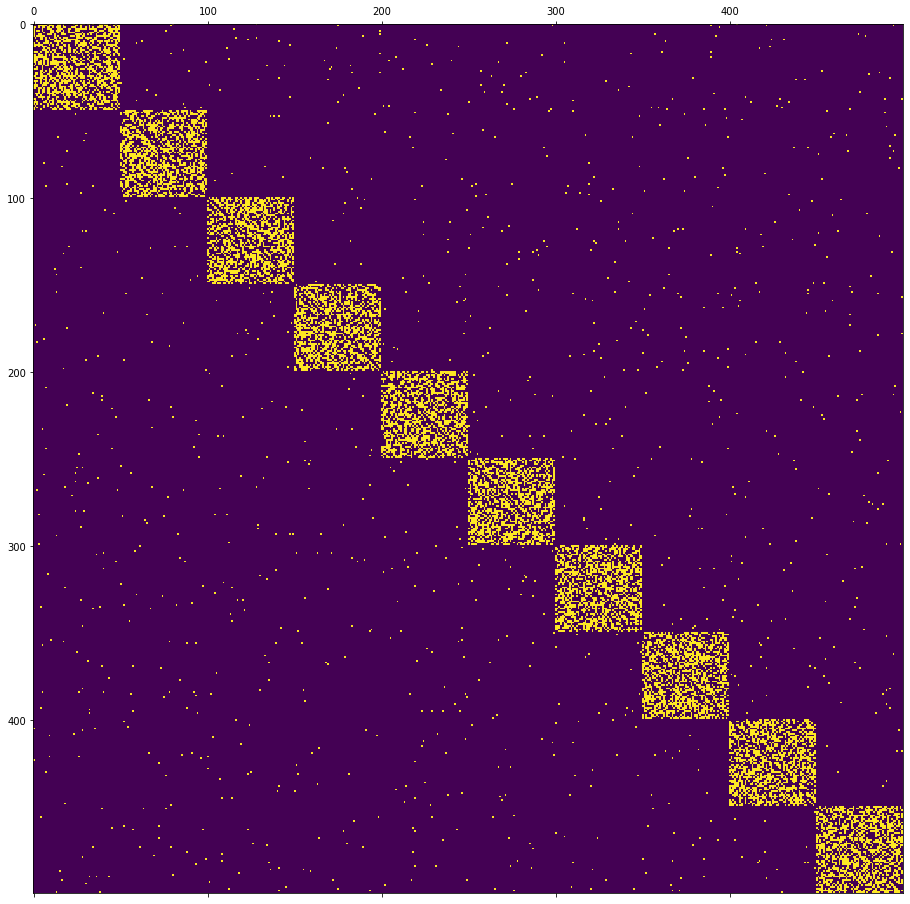

In [ ]:
#@title Launch { form-width: "300px" }

source_fn_name = 'create_sbm'
source_fn_args = {'n':500, 'q':10, 'random_sizes': 0}

#source_fn_name = 'create_er'
#source_fn_args = {'n':200, 'p':0.2}
 
#source_fn_name = 'create_rrg'
#source_fn_args = {'n':200, 'd': 5}
 
#source_fn_name = 'create_ba'
#source_fn_args = {'n':2000, 'm': 5}
 
#source_fn_name = 'create_ws'
#source_fn_args = {'n':4000, 'k': 10, 'p': 1.0}
 
#source_fn_name = 'create_rgg'
#source_fn_args = {'n':1000, 'radius': 0.1, 'dim': 2}
 
#source_fn_name = 'create_ucm'
#source_fn_args = {'n':2000, 'g': 3}
 
#source_fn_name = 'create_barbell'
#source_fn_args = {'n':2000, 'd': 10, 'interlinks': 20}
 
#source_fn_name = 'create_multibarbell'
#source_fn_args = {'n':500, 'd': 20, 'interlinks1': 5, 'interlinks2': 25, 
#                  'interlinks3': 125, 'mode': 'equal'}
 
#source_fn_name = 'nematode'
#source_fn_args = {}
 
#source_fn_name = 'macacue'
#source_fn_args = {}
 
#source_fn_name = 'pit_human'
#source_fn_args = {'idx': 101006, 'comparison': 0}
 
#source_fn_name = 'hagmann_human'
#source_fn_args = {}
 
#source_fn_name = 'assoc_swow'
#source_fn_args = {'weight_thr':0.07}
 
#source_fn_name = 'assoc_rus'
#source_fn_args = {'weight_thr':80}
 
#source_fn_name = 'create_sausage'
#source_fn_args = {'n':2000, 'k':20, 'dlinks':1000}
 
network_args = {'weighted': 1.0, 'directed': 1.0}
spectrum_args = {'mode': 'a', 'noise': 0.0, 'n_eigs': None}
ensemble_size = 100
 
new_ensemble = 1
if new_ensemble:
    ensemble = get_ensemble(source_fn_name, source_fn_args, 
                        network_args, spectrum_args, ensemble_size = ensemble_size,
                        force_spectrum = 0, check_connectivity = 0)
    
net = ensemble[0]
#print(net.adj.nnz)
#net.sausage_index(source_fn_args['k'])
net.show(dtype = bool)
#net.draw_degree_distr(cumulative = 1, log_log = 1)
#net.draw_spectrum()
#get_spectrum_stats(net)
#net.draw_eigenvectors(1,9)
#net.plot_lem_embedding(5)
#plot_2d_z_distr(ensemble)
#plot_marginal_z_distr(ensemble)
#plot_separate(arr)
#plot_separate_marginal_distr(ensemble, nbins = 100)
#plot_modified_separate_marginal_distr(ensemble, nbins = 100)
#get_localization_stats(ensemble)
#get_separate_average_vals(arr)
#get_average_vals(arr)
#plot_angle_z_distr(arr)
#plot_radial_z_distr(arr)
#plot_ipr_entropy(ensemble, separate = 1)
#plot_2d_ipr_entropy(ensemble)
#plot_degree_eigenvector_correlation(ensemble)

In [ ]:
plot_2d_z_distr(ensemble)

In [ ]:
net.draw_spectrum()

In [ ]:
net.localization_signatures()
#net.draw_degree_distr(log_log=True, cumulative=1)
#plot_2d_z_distr(ensemble)
plot_separate_marginal_distr(ensemble, nbins = 100)

In [ ]:
#@title Series of experiments { form-width: "300px" }
from itertools import product

PATH = '/content/drive/My Drive/Colab Notebooks/Networks/SBM results/500'
 
dirlist = [0.0, 0.25, 0.5, 0.75, 1.0]
rlist = [1, 100, 350, 1000, 3500, 10000]

N=1000
Q=10
ensemble_size = 100
zdata = {(x,y):[] for x in dirlist for y in rlist}

for i, directed in enumerate(dirlist, start = 1):
    for j, ratio in enumerate(rlist, start = 1):

        source_fn_name = 'create_sbm'
        source_fn_args = {'n':N, 'q': Q, 'w_in': ratio*0.01}
        network_args = {'weighted': 1.0, 'directed': directed}
        spectrum_args = {'mode': 'a', 'noise': 0.0, 'n_eigs': None}
 
        ensemble = get_ensemble(source_fn_name, source_fn_args, 
                                network_args, spectrum_args, ensemble_size = ensemble_size,
                                force_spectrum = 0, check_connectivity = 0)

        '''
        plot_separate_marginal_distr(ensemble, nbins = 100)
        name = str(i) + '.'+str(j)+'.SBM n={} q={} rat='.format(N,Q) +str(w_in/0.01)+ ' dir='+ str(directed) + '.png'
        fname = os.path.join(PATH, name)
        plt.savefig(fname)
        '''
        zvals = ravel_ensemble_data(ensemble, ['zvalues'])[0]
        zdata[(directed, ratio)] = zvals

In [ ]:
#@title Series marginal distributions { form-width: "300px" }
nbins = 100
xl, yl = len(dirlist), len(rlist)
fig1, axes1 = plt.subplots(nrows = xl, ncols = yl, figsize = (xl*6, yl*6))
fig2, axes2 = plt.subplots(nrows = xl, ncols = yl, figsize = (xl*6, yl*6))
fig3, axes3 = plt.subplots(nrows = xl, ncols = yl, figsize = (xl*6, yl*6))

for i in range(xl):
    for j in range(yl):
        ax1, ax2, ax3 = axes1[i,j], axes2[i,j], axes3[i,j]
        data = zdata[(dirlist[i], rlist[j])]
        z_complex, z_real = separate(data)
        plot_radial_z_distr(z_complex, ax = ax1, nbins = nbins)
        plot_angle_z_distr(z_complex, ax = ax2, nbins = nbins)
        plot_radial_z_distr(z_real, ax = ax3, nbins = nbins)

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/Networks/SBM results/1000 txt'
for i, directed in enumerate(dirlist, start = 1):
    for j, ratio in enumerate(rlist, start = 1):
        data = zdata[(directed, w_in)]
        name = str(i) + '.'+str(j)+'.SBM nnets={} n={} q={} rat={} dir={}.txt'.format(ensemble_size,N,Q,ratio,directed)
        fname = os.path.join(PATH, name)
        np.savetxt(fname, data, delimiter=',')   # X is an array

In [ ]:
net = ensemble[0]
rnet = net.randomize()

#fig, ax = plt.subplots(figsize = (10,10))
#net.draw_spectrum(ax = ax)
#rnet.draw_spectrum(ax = ax)
#plot_2d_z_distr([net])
#plot_2d_z_distr([rnet])
r_ensemble = []
arraylist = []
for i in tqdm.tqdm(range(100)):
    rnet = net.randomize()
    rnet.calculate_z_values()
    arraylist.append(rnet.zvalues)
    #r_ensemble.append(rnet)

plot_separate_marginal_distr(r_ensemble, arraylist = arraylist, nbins = 50)

In [ ]:
#@title Associative network { form-width: "300px" }
PATH = '/content/drive/My Drive/Colab Notebooks/Networks/Russian word map/Results'

def select_optimal_nrand(N):
    if N > 5000:
        nrand = 1
    elif N > 1000:
        nrand = 10
    else:
        nrand = 100
    
    return nrand

def compare_to_random(i, weight_thr, save_figures = 1):
    source_fn_name = 'assoc_rus'
    source_fn_args = {'weight_thr': weight_thr}


    network_args = {'weighted': 1, 'directed': 1.0}
    spectrum_args = {'mode': 'l_out', 'noise': 0.0, 'n_eigs': None}
    ensemble_size = 1

    ensemble = get_ensemble(source_fn_name, source_fn_args, 
                            network_args, spectrum_args, ensemble_size = ensemble_size,
                            force_spectrum = 0)
        
    net = ensemble[0]


    name = str(i) + 'assoc rus Z thr ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    ax = plot_2d_z_distr(ensemble, return_figure = 1)
    if save_figures:
        plt.savefig(fname)

    name = str(i) +'assoc rus spectrum ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    net.draw_spectrum()
    if save_figures:
        plt.savefig(fname)

    name = str(i) +'assoc rus Z marginal thr ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    plot_separate_marginal_distr(ensemble, nbins = 50)
    if save_figures:
        plt.savefig(fname)

    rnet = net.randomize()
    rnet.calculate_z_values()
    r_ensemble = [rnet]
    full_ensemble = [net] + [r_ensemble[0]]

    name = str(i) +'assoc rus rand spectrum ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    rnet.draw_spectrum()
    if save_figures:
        plt.savefig(fname)

    name = str(i) +'assoc rus IPR entropy thr ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    plot_ipr_entropy(full_ensemble, separate = 1, first_eigs = 1)
    if save_figures:
        plt.savefig(fname)

    r_ensemble = []
    arraylist = []
    N = net.adj.shape[0]
    nrand = select_optimal_nrand(N)

    rstatlist_1 = []
    rstatlist_2 = []
    for i in tqdm.tqdm(range(nrand)):
        rnet = net.randomize()
        rnet.calculate_z_values()
        arraylist.append(rnet.zvalues)
        rst1, rst2 = rnet.localization_signatures()
        rstatlist_1.append(rst1)
        rstatlist_2.append(rst2)
        #r_ensemble.append(rnet)

    name = str(i) +'assoc rus Z marginal rand=' + str(nrand)+'thr ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    plot_separate_marginal_distr(r_ensemble, arraylist = arraylist, nbins = 50)
    if save_figures:
        plt.savefig(fname)

    name = str(i) +'assoc rus Z rand=' + str(nrand)+'thr ' + str(source_fn_args['weight_thr']) + '.png'
    fname = os.path.join(PATH, name)
    plot_2d_z_distr(r_ensemble, arraylist = arraylist)
    if save_figures:
        plt.savefig(fname)
    
    st1, st2 = net.localization_signatures()
    rst1 = np.mean(np.array(rstatlist_1))
    rst2 = np.mean(np.array(rstatlist_2))

    return st1, st2, rst1, rst2

In [ ]:
thrs = np.linspace(45, 100, 10)
stlist1 = []
stlist2 = []
rstlist1 = []
rstlist2 = []

for i in range(len(thrs)):
    thr = thrs[i]
    print('-----------------------------------')
    print('thr=', thr)
    print('-----------------------------------')
    st1, st2, rst1, rst2 = compare_to_random(i, thr, save_figures = 1)
    stlist1.append(st1)
    stlist2.append(st2)
    rstlist1.append(rst1)
    rstlist2.append(rst2)

In [ ]:
#@title PIT human edges cut { form-width: "300px" }
import tqdm
import imageio
from os import listdir, remove
from os.path import isfile, join
from IPython.utils import io

PATH = '/content/drive/My Drive/Colab Notebooks/Networks/PIT human/For GIFs'

def get_strong_edges():
    lst1 = [223, 224, 81, 80, 223, 228, 224, 224, 224, 84, 82, 224, 227, 224, 223, 224, 229]
    lst2 = [456, 456, 456, 456, 455, 462, 309, 312, 459, 456, 456, 455, 462, 462, 462, 311, 462]
    return lst1, lst2

def get_non_strong_edges(idx):
    l1 = [223, 224, 81, 80, 223, 228, 224, 224, 224, 84, 82, 224, 227, 224, 223, 224, 229]
    l2 = [456, 456, 456, 456, 455, 462, 309, 312, 459, 456, 456, 455, 462, 462, 462, 311, 462]
    interedges = find_interhemisphere_edges(idx)
    strong_edges = list(zip(l1, l2))
    strong_edges = [(str(e[0]), str(e[1])) for e in strong_edges]
    inv_strong_edges = [(e[1], e[0]) for e in strong_edges]

    non_strong_edges = [e for e in interedges if e not in strong_edges and e not in inv_strong_edges]
    print(interedges)
    print(strong_edges)
    print(non_strong_edges)
    print(len(interedges))
    print(len(strong_edges))
    print(len(non_strong_edges))

    lst1 = [e[0] for e in non_strong_edges]
    lst2 = [e[1] for e in non_strong_edges]

    return lst1, lst2

def get_interhemisphere_edges(idx):
    interedges = find_interhemisphere_edges(idx)
    lst1 = [e[0] for e in interedges]
    lst2 = [e[1] for e in interedges]

    return lst1, lst2

def find_interhemisphere_edges(idx):

    name = str(idx) + '_connectome_scale250.graphml'
    datadir = os.path.join(path, 'PIT human')
    dpath = os.path.join(datadir, name)
    g = nx.read_graphml(dpath)
    G = remove_isolates_and_selfloops_from_graph(g)
    g = take_giant_component(G)

    #hemisphere = [n[1]['dn_hemisphere'] for n in (g.nodes(data=True))]
    interhemisphere_edges = [(u,v) for u, v, d in (g.edges(data=True)) if g.nodes[u]['dn_hemisphere']!= g.nodes[v]['dn_hemisphere']]
    return interhemisphere_edges

def destroy_previous():
    # destroy all previous images
    all_prev_files = [f for f in listdir(PATH) if isfile(join(PATH, f))]
    for f in all_prev_files:
        remove(join(PATH,f))

def create_image_series(idx, l1, l2):
    lst1 = [227, 217, 217, 226, 227, 224, 227, 224, 226, 223, 225, 227, 228, 87, 84, 80, 224, 82, 225, 223, 81, 227, 227, 166, 226, 139, 90, 228, 112, 42, 103, 108, 89, 140, 90, 87, 89, 90, 89, 90, 87, 89, 140, 90, 11, 90, 90, 226, 28, 25, 26, 23, 83, 90, 89, 223, 87, 140, 225, 226, 229, 226, 228, 171, 225, 219, 89, 227, 223, 28, 82, 227, 223, 224, 84, 229, 81, 87, 89, 224, 89, 90, 224, 223, 87, 226, 89, 111, 81, 81, 224, 16, 87, 85, 105, 224, 25, 90, 227, 216, 216, 81, 228, 85, 225, 68, 24, 56, 125, 224, 227, 124, 90, 224, 87, 223, 85, 228, 217, 223, 225, 228, 114, 112, 225, 228, 224, 223, 216, 216, 216, 87, 224, 82, 225, 111, 85, 89, 90, 227, 225, 224, 89, 225, 11, 83, 225, 224, 224, 111, 22, 27, 22, 84, 15, 84, 223, 111, 80, 80, 167, 81, 85, 88, 84, 68, 128, 224, 80, 82, 82, 82, 216, 81, 82, 223, 28, 224, 80, 86, 1, 222, 41, 138, 90, 109, 91, 48, 89, 111, 81, 89, 48, 44, 224, 171, 80, 228, 102, 89, 224, 82, 82, 152, 155, 87, 83, 34, 3, 226, 223, 82, 216, 80, 14, 14, 81, 84, 34, 11, 222, 3, 220, 85, 224, 224, 90, 227, 228, 229, 224, 222, 76, 110, 112, 15, 224, 225, 15, 112, 112, 218, 82, 223, 224, 111, 90, 225, 90, 223, 81, 111, 18, 90, 224, 18, 80, 224, 80, 25, 14, 81, 81, 224, 82, 37, 25, 25, 223, 216, 85, 90, 229, 81, 215, 167, 138, 72, 224, 53, 168, 110, 223, 43, 227, 227, 80, 42, 81, 15, 82, 15, 27, 82, 224, 62, 53, 224, 102, 73, 216, 167, 81, 80, 80, 80, 20, 25, 221, 212, 115, 125, 125, 110, 146, 125, 224, 225, 224, 154, 146, 161, 27, 27, 36]
    lst2 = [456, 456, 455, 462, 314, 314, 459, 255, 459, 459, 456, 455, 455, 455, 314, 309, 313, 313, 458, 317, 312, 461, 244, 380, 455, 455, 318, 318, 318, 318, 318, 319, 273, 273, 312, 312, 312, 254, 254, 274, 274, 274, 274, 317, 317, 271, 456, 456, 456, 456, 456, 456, 456, 314, 314, 314, 313, 313, 461, 461, 460, 460, 460, 460, 462, 462, 252, 458, 309, 309, 309, 309, 310, 310, 457, 455, 311, 456, 456, 317, 317, 455, 457, 458, 459, 458, 455, 456, 313, 457, 453, 456, 314, 456, 455, 249, 252, 460, 313, 462, 455, 310, 319, 455, 455, 456, 456, 456, 318, 271, 310, 380, 342, 252, 317, 460, 314, 456, 462, 318, 457, 459, 305, 317, 317, 317, 318, 346, 317, 456, 318, 460, 319, 310, 310, 462, 459, 339, 339, 460, 309, 460, 319, 459, 456, 311, 311, 296, 458, 455, 456, 311, 311, 310, 310, 309, 319, 319, 312, 311, 396, 459, 309, 455, 311, 462, 462, 233, 233, 312, 311, 318, 298, 268, 268, 313, 310, 248, 260, 455, 456, 456, 311, 319, 319, 462, 455, 455, 401, 318, 453, 318, 456, 456, 284, 455, 310, 378, 307, 460, 287, 273, 274, 385, 381, 462, 284, 456, 456, 457, 457, 457, 457, 459, 459, 309, 309, 455, 455, 455, 455, 458, 462, 318, 232, 236, 378, 453, 458, 458, 230, 311, 292, 455, 456, 456, 260, 260, 260, 342, 462, 456, 315, 312, 241, 460, 458, 314, 457, 334, 252, 314, 456, 377, 244, 457, 457, 231, 458, 310, 462, 247, 267, 247, 247, 456, 311, 316, 448, 448, 317, 448, 459, 255, 455, 385, 455, 456, 294, 456, 399, 456, 461, 311, 457, 243, 244, 456, 260, 252, 252, 247, 249, 284, 282, 313, 313, 250, 304, 304, 319, 398, 269, 314, 316, 315, 455, 460, 462, 462, 317, 339, 456, 348, 344, 342, 285, 252, 256, 397, 318, 381, 310, 456, 456]
    all_edges_to_del = list(zip(l1, l2))

    for cut_edges in range(1, len(all_edges_to_del)+1):
        source_fn_name = 'pit_human'
        source_fn_args = {'idx': idx, 'comparison': 1, 'cut_edges':cut_edges,
                        'all_edges_to_del': all_edges_to_del}
        
        network_args = {'weighted': 0.0, 'directed': 0.0}
        spectrum_args = {'mode': 'nl', 'noise': 0.0, 'n_eigs': None}
        ensemble_size = 1
        
        new_ensemble = 1
        if new_ensemble:
            ensemble = get_ensemble(source_fn_name, source_fn_args, 
                                network_args, spectrum_args, ensemble_size = ensemble_size,
                                force_spectrum = 0, check_connectivity = 1)
            
        net = ensemble[0]
        fig, ax = plt.subplots(figsize = (16,12))
        plot_ipr_entropy(ensemble, separate = 1, ax = ax)
        ax.set_title('id = '+str(idx)+' cut = '+str(cut_edges))
        ax.set_xlabel('normalized laplacian eigenvalue')
        ax.set_ylabel('eigenvector Erdos entropy')
        plt.savefig(join(PATH, 'id = '+str(idx)+' cut = '+str(cut_edges)))
        plt.close()

#create_image_series(100307)

In [ ]:

def create_gif(idx):
    destroy_previous()
    l1, l2 = get_non_strong_edges(idx)
    #l1, l2 = get_strong_edges(idx)
    #l1, l2 = get_interhemisphere_edges(idx)
    create_image_series(idx, l1, l2)

    images = []
    print([f for f in listdir(PATH)])
    files = [f for f in listdir(PATH) if isfile(join(PATH, f)) and str(idx) in f]

    sorted(files)
    for filename in tqdm.tqdm(files, leave = True, position = 0):
        images.append(imageio.imread(join(PATH, filename)))

    imageio.mimsave(join(PATH, 'GIFs', 'id = '+str(idx) + '.gif'),
                    images, duration=0.5)

create_gif(100307)

In [ ]:
import matplotlib.pyplot as plt

def calculate_ipr(eigenvectors):

    '''
    eigenvectors have the shape of (N_nodes, N_components)
    '''

    nvecs = eigenvectors.shape[1]
    ipr = np.zeros(nvecs)
    entropy = np.zeros(nvecs)
    for i in range(nvecs):
        ipr[i] = sum([np.abs(v)**4 for v in eigenvectors[:,i]])
        entropy[i] = -np.log(ipr[i])

    return ipr, entropy

def plot_ipr_entropy(eigvals_list, eigenvectors_list, first_eigs = 1, ax = None):

    '''
    -  "eigvals_list" is a list of arrays containing connectome spectra
    -  "eigenvectors_list" is a list of eigenvector matrices of shape (N_nodes, N_components)
    -  "first eigs" plots first 20 points only
    '''

    if ax is None:
        fig, ax = plt.subplots(figsize = (15,10))
    
    ax.set_ylabel('ipr entropy')
    ax.set_xlabel('lambda')
    #change_labels_color(ax)
    clist = ['k', 'y', 'b', 'g', 'm']
    
    entropy_list = []
    for eigenvectors in eigenvectors_list:
        ipr, entropy = calculate_ipr(eigenvectors)
        entropy_list.append(entropy)
    
    ax.set(ylim = (0, max(max(entropy_list[0]), max(entropy_list[1])) + 0.5))
    for i in range(len(eigvals_list)):
        entropy = entropy_list[i]
        eigvals = eigvals_list[i]
        if first_eigs:
            ax.scatter(eigvals[:20], entropy[:20], c = clist[i])
        else:
            ax.scatter(eigvals, entropy, c = clist[i])

